# The Goal

Our goal here is to build a personal image search engine. Given our dataset of vacation photos, we want to make this dataset “search-able” by creating a “more like this” functionality — this will be a “search by example” image search engine. For instance, if I submit a photo of sail boats gliding across a river, our image search engine should be able to find and retrieve our vacation photos of when we toured the marina and docks.


In order to build this system, we’ll be using a simple, yet effective image descriptor: **the color histogram**.

**Assumption:** Images that have similar color distributions will be considered relevant to each other. Even if images have dramatically different contents, they will still be considered “similar” provided that their color distributions are similar as well.

**This is a really important assumption,** but is normally a fair and reasonable assumption to make when using color histograms as image descriptors.

# Step 1: Defining our Image Descriptor

Instead of using a standard color histogram, we are going to apply a few tricks and make it a little more robust and powerful.

Our image descriptor will be a 3D color histogram in the HSV color space (Hue, Saturation, Value). Typically, images are represented as a 3-tuple of Red, Green, and Blue (RGB). We often think of the RGB color space as “cube”. However, while RGB values are simple to understand, the RGB color space fails to mimic how humans perceive color. Instead, we are going to use the HSV color space which maps pixel intensities into a cylinder.

There are other color spaces that do an even better job at mimicking how humans perceive color, such as the CIE L\*a\*b\* and CIE XYZ spaces, but let’s keep our color model relatively simple for our first image search engine implementation.

So now that we have selected a color space, we now need to define the number of bins for our histogram. Histograms are used to give a (rough) sense of the density of pixel intensities in an image. Essentially, our histogram will estimate the probability density of the underlying function, or in this case, the probability P of a pixel color C occurring in our image I.

It’s important to note that there is a trade-off with the number of bins you select for your histogram. If you select too few bins, then your histogram will have less components and unable to disambiguate between images with substantially different color distributions. Likewise, if you use too many bins your histogram will have many components and images with very similar contents may be regarded and “not similar” when in reality they are.

<img src="docs/histogram_many_bins.jpg" style="height: 300px;">

For our vacation photo image search engine, we’ll be utilizing a 3D color histogram in the HSV color space with 8 bins for the Hue channel, 12 bins for the saturation channel, and 3 bins for the value channel, yielding a total feature vector of dimension 8 x 12 x 3 = 288.

This means that for every image in our dataset, no matter if the image is 36 x 36 pixels or 2000 x 1800 pixels, all images will be abstractly represented and quantified using only a list of 288 floating point numbers.

I think the best way to explain a 3D histogram is to use the conjunctive AND. A 3D HSV color descriptor will ask a given image how many pixels have a Hue value that fall into bin #1 AND how many pixels have a Saturation value that fall into bin #1 AND how many pixels have a Value intensity that fall into bin #1. The number of pixels that meet these requirements are then tabulated. This process is repeated for each combination of bins; however, we are able to do it in an extremely computationally efficient manner.

Pretty cool, right?

Instead of computing a 3D HSV color histogram for the entire image, let’s instead compute a 3D HSV color histogram for different regions of the image.

Using regions-based histograms rather than global-histograms allows us to simulate locality in a color distribution. For example, take a look at this image below.

In this photo we can clearly see a blue sky at the top of the image and a sandy beach at the bottom. Using a global histogram we would be unable to determine where in the image the “blue” occurs and where the “brown” sand occurs. Instead, we would just know that there exists some percentage of blue and some percentage of brown.

To remedy this problem, we can compute color histograms in regions of the image:

<img src="docs/image_segments.jpg" style="height: 300px;">

For our image descriptor, we are going to divide our image into five different regions: (1) the top-left corner, (2) the top-right corner, (3) the bottom-right corner, (4) the bottom-left corner, and finally (5) the center of the image.

By utilizing these regions we’ll be able to mimic a crude form of localization, being able to represent our above beach image as having shades of blue sky in the top-left and top-right corners, brown sand in the bottom-left and bottom-right corners, and then a combination of blue sky and brown sand in the center region.

If we were to animate this process of looping over the corner segments it would look something like this:

<img src="docs/mask_segments.gif" style="height: 300px;">

In [1]:
import numpy as np
import cv2
 
class ColorDescriptor:
    def __init__(self, bins):
        # store the number of bins for the 3D histogram
        self.bins = bins

    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        # divide the image into four rectangles/segments (top-left,
        # top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
            (0, cX, cY, h)]

        # construct an elliptical mask representing the center of the
        # image
        (axesX, axesY) = (int(w * 0.75) / 2, int(h * 0.75) / 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (int(cX), int(cY)), (int(axesX), int(axesY)), 0, 0, 360, 255, -1)

        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)

            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)

        # return the feature vector
        return features

    def histogram(self, image, mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel; then
        # normalize the histogram
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
            [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # return the histogram
        return hist

# Step 2: Extracting Features from Our Dataset

In [3]:
import argparse
import glob
import cv2
import os
from tqdm import tqdm

# initialize the color descriptor
cd = ColorDescriptor((8, 12, 3))

# open the output index file for writing
output = open("indexes/holidays.idx", "w")

# use glob to grab the image paths and loop over them
for imagePath in tqdm(glob.glob("holidays/*.jpg")):
	# extract the image ID (i.e. the unique filename) from the image
	# path and load the image itself
	imageID = imagePath[imagePath.rfind("/") + 1:]
	image = cv2.imread(imagePath)
 
	# describe the image
	features = cd.describe(image)
 
	# write the features to file
	features = [str(f) for f in features]
	output.write("%s,%s\n" % (imageID, ",".join(features)))

# close the index file
output.close()

print("Indexes saved with size(Bytes): {}".format(os.stat('indexes/holidays.idx').st_size))

100%|██████████| 1491/1491 [04:40<00:00,  5.32it/s]

Indexes saved with size(Bytes): 15757943


# Step 3: The Searcher

We use the chi-squared distance to compare our color histograms. 

Why the name chisquare distance? The chisquare test for contingency tables is based on

$\tilde{\chi}^2=\frac{1}{d}\sum_{k=1}^{n} \frac{(O_k - E_k)^2}{E_k}$

Reference:
- http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm
- https://stats.stackexchange.com/questions/184101/comparing-two-histograms-using-chi-square-distance

In [6]:
import csv
class Searcher:
    def __init__(self, indexPath):
        # store our index path
        self.indexPath = indexPath

    def search(self, queryFeatures, limit = 10):
        # initialize our dictionary of results
        results = {}
    # open the index file for reading
        with open(self.indexPath) as f:
            # initialize the CSV reader
            reader = csv.reader(f)

            # loop over the rows in the index
            for row in reader:
                # parse out the image ID and features, then compute the
                # chi-squared distance between the features in our index
                # and our query features
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, queryFeatures)

                # now that we have the distance between the two feature
                # vectors, we can udpate the results dictionary -- the
                # key is the current image ID in the index and the
                # value is the distance we just computed, representing
                # how 'similar' the image in the index is to our query
                results[row[0]] = d

            # close the reader
            f.close()

        # sort our results, so that the smaller distances (i.e. the
        # more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])

        # return our (limited) results
        return results[:limit]
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
            for (a, b) in zip(histA, histB)])

        # return the chi-squared distance
        return d

### Image Viewer

In [14]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt

from io import BytesIO
import PIL
from IPython.display import display, Image

def display_img_array(ima):
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png'))

# Step 4: Performing a Search

Query


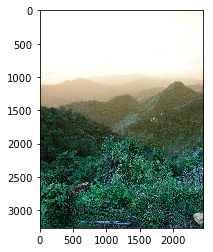

Result: holidays/100000.jpg


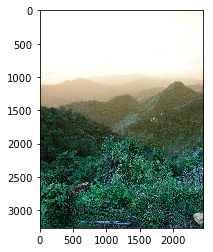

Result: holidays/100001.jpg


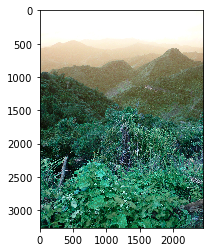

Result: holidays/100501.jpg


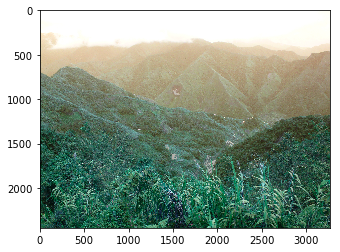

Result: holidays/100503.jpg


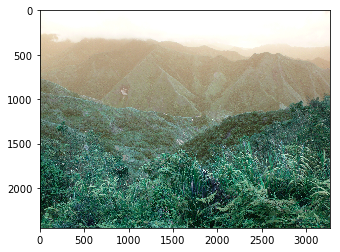

Result: holidays/100002.jpg


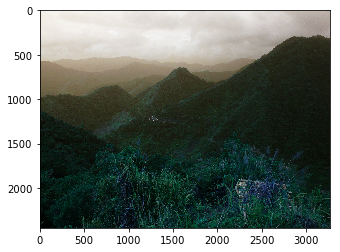

Result: holidays/107902.jpg


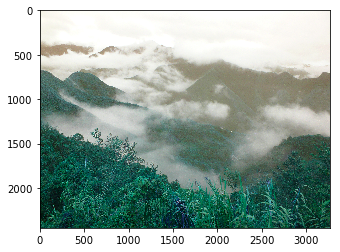

Result: holidays/136008.jpg


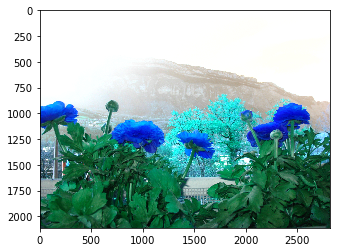

Result: holidays/113701.jpg


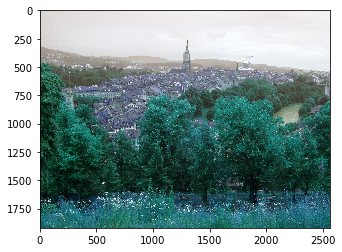

Result: holidays/136010.jpg


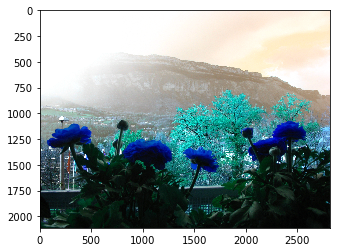

Result: holidays/122200.jpg


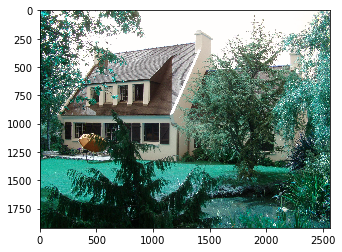

CPU times: user 16.8 s, sys: 96 ms, total: 16.9 s
Wall time: 21.5 s


In [17]:
%%time

# load the query image and describe it
query = cv2.imread("holidays/100000.jpg")
features = cd.describe(query)
 
# perform the search
searcher = Searcher('indexes/holidays.idx')
results = searcher.search(features)
 
# display the query
print("Query")
plt.imshow(query)
plt.show()
 
# loop over the results
for (score, resultID) in results:
    # load the result image and display it
    result = cv2.imread("holidays/" + resultID)
    print("Result: {}".format("holidays/" + resultID))
    plt.imshow(result)
    plt.show()

Time 21 second. Not very nice.

In [ ]:
%%time

# load the query image and describe it
query = cv2.imread("holidays/100000.jpg")
features = cd.describe(query)
 
# perform the search
searcher = Searcher('indexes/holidays.idx')
results = searcher.search(features)
 
# display the query
print("Query")
plt.imshow(query)
 
# loop over the results
for (score, resultID) in results:
    # load the result image and display it
    result = cv2.imread(args["result_path"] + "/" + resultID)
    print("Result")
    plt.imshow(result)